## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7-minimal
Suggested packages:
  python3.7-venv binfmt-support
The following NEW packages will be installed:
  libpython3.7-minimal libpython3.7-stdlib mailcap mime-support python3.7 python3.7-minimal
0 upgraded, 6 newly installed, 0 to remove and 6 not upgraded.
Need to get 4,698 kB of archives.
After this operation, 17.8 MB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 libpython3.7-minimal amd64 3.7.17-1+jammy1 [608 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 mailcap all 3.70+nmu1ubuntu1 [23.8 kB]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 python3.7-minimal amd64 3.7.17-1+jammy1 [1,837 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mi

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [6]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

In [7]:
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/val.en.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.de.gz -P ./data/multi30k
!wget https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/test_2016_flickr.en.gz -P ./data/multi30k

--2023-11-14 12:52:03--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.de.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 637044 (622K) [application/octet-stream]
Saving to: ‘./data/multi30k/train.de.gz’

train.de.gz         100%[===================>] 622.11K  --.-KB/s    in 0.02s   

2023-11-14 12:52:04 (32.0 MB/s) - ‘./data/multi30k/train.de.gz’ saved [637044/637044]

--2023-11-14 12:52:04--  https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/train.en.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

In [8]:
!gzip -d ./data/multi30k/train.de.gz
!gzip -d ./data/multi30k/train.en.gz
!gzip -d ./data/multi30k/val.de.gz
!gzip -d ./data/multi30k/val.en.gz
!gzip -d ./data/multi30k/test_2016_flickr.en.gz
!gzip -d ./data/multi30k/test_2016_flickr.de.gz

In [9]:
!mv ./data/multi30k/test_2016_flickr.de ./data/multi30k/test2016.de
!mv ./data/multi30k/test_2016_flickr.en ./data/multi30k/test2016.en

In [10]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG), root = './data')

In [11]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [12]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different.
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token.
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [13]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [14]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [15]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [17]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, input, mask):

        ## TODO: write down the forward step
        batch_size, input_len = input.shape[0], input.shape[1]
        position_index = torch.arange(0, input_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        output = (self.tok_embedding(input) * self.scale) + self.pos_embedding(position_index)
        output = self.dropout(output)
        for layer in self.layers:
            output = layer(output, mask)

        return output

### Encoer layer

In [19]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self-Attention '''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        # TODO: write your code

        src_temp, attention = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(src_temp))
        src_temp = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(src_temp))

        return src

### Multi Head Attention Layer

In [20]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()

        # TODO: write your code
        self.ff_query = nn.Linear(hid_dim, hid_dim)
        self.ff_key = nn.Linear(hid_dim, hid_dim)
        self.ff_value = nn.Linear(hid_dim, hid_dim)
        self.ff_output = nn.Linear(hid_dim, hid_dim)

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

      # TODO: write your code

      batch_size = query.shape[0]
      query = self.ff_query(query)
      key = self.ff_key(key)
      value = self.ff_value(value)

      query = query.reshape(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
      key = key.reshape(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
      value = value.reshape(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

      attention_values = torch.matmul(query, key.transpose(-2, -1)) / self.scale

      if mask is not None:
          attention_values = attention_values.masked_fill(mask == 0, -1e10)

      attention_distribution = torch.softmax(attention_values, dim=-1)
      x = torch.matmul(self.dropout(attention_distribution), value)

      x = x.transpose(1, 2).reshape(batch_size, -1, self.hid_dim)
      x = self.ff_output(x)

      return x, attention_distribution



### Position-wise Feedforward Layer

In [22]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()

        # TODO: write your code
        self.dropout = nn.Dropout(dropout)
        self.feed_forward1 = nn.Linear(hid_dim, pf_dim)
        self.feed_forward2 = nn.Linear(pf_dim, hid_dim)

    def forward(self, x):

      # TODO: write your code
      x = self.dropout(torch.relu(self.feed_forward1(x)))
      x = self.feed_forward2(x)
      return x

### Decoder

In [23]:
class Decoder(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)

        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim,
                                                  n_heads,
                                                  pf_dim,
                                                  dropout,
                                                  device)
                                     for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # TODO: write your code

        batch_size, trg_len = trg.shape[0], trg.shape[1]
        position_index = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        trg = self.tok_embedding(trg) * self.scale + self.pos_embedding(position_index)
        trg = self.dropout(trg)

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        output = self.fc_out(trg)
        return output, attention


### Decoder Layer

In [24]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim,
                                                                     pf_dim,
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

       # TODO: write your code

        trg_temp, attention = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(trg_temp))
        trg_temp, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(trg_temp))
        trg_temp = self.positionwise_feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(trg_temp))

        return trg, attention

### Sequence-to-sequence model

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def trg_mask(self, trg_seq):
        trg_pad_idx = (trg_seq != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # Generate a lower triangular mask to attend to previous positions in the target sequence
        target_length = trg_seq.shape[1]
        target_subsequent_mask = torch.tril(torch.ones((target_length, target_length), device=self.device)).bool()
        target_mask = trg_pad_idx & target_subsequent_mask

        return target_mask

    def forward(self, src, trg):

        ## TODO: write down the forward step

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_mask = self.trg_mask(trg)
        encoder_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, encoder_src, trg_mask, src_mask)

        return output, attention

### Training the Seq2Seq Model

In [26]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

In [27]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


We initialize model weights

In [29]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [32]:
def train(model, iterator, optimizer, criterion):

    model.train()

    epoch_loss = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        # TODO: write down your training code here

        pred, _ = model(src, trg[:,:-1])
        output_dim = pred.shape[-1]

        pred = pred.contiguous().reshape(-1, output_dim)
        trg = trg[:,1:].contiguous().reshape(-1)

        loss = criterion(pred, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

### Evaluation

In [33]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            # TODO: write down your training code here
            pred, _ = model(src, trg[:,:-1])
            output_dim = pred.shape[-1]
            pred = pred.contiguous().reshape(-1, output_dim)
            trg = trg[:,1:].contiguous().reshape(-1)
            loss = criterion(pred, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [35]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 18s
	Train Loss: 4.326
	 Val. Loss: 3.106
Epoch: 02 | Time: 0m 14s
	Train Loss: 2.880
	 Val. Loss: 2.325
Epoch: 03 | Time: 0m 15s
	Train Loss: 2.254
	 Val. Loss: 1.984
Epoch: 04 | Time: 0m 15s
	Train Loss: 1.883
	 Val. Loss: 1.815
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.626
	 Val. Loss: 1.714
Epoch: 06 | Time: 0m 15s
	Train Loss: 1.433
	 Val. Loss: 1.650
Epoch: 07 | Time: 0m 15s
	Train Loss: 1.282
	 Val. Loss: 1.622
Epoch: 08 | Time: 0m 14s
	Train Loss: 1.153
	 Val. Loss: 1.625
Epoch: 09 | Time: 0m 14s
	Train Loss: 1.045
	 Val. Loss: 1.640
Epoch: 10 | Time: 0m 15s
	Train Loss: 0.949
	 Val. Loss: 1.656


In [36]:
# model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.710


### Inference and attention visualization

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [38]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()

    # TODO: write your code

    # add star and and end tokens
    src_tokens = sentence.copy()
    src_tokens.insert(0, src_field.init_token)
    src_tokens.append(src_field.eos_token)

    # convert source tokens to indices
    src_indices = [src_field.vocab.stoi[token] for token in src_tokens]

    src = torch.LongTensor(src_indices).unsqueeze(0).to(device)

    trg_indices = [trg_field.vocab.stoi["<sos>"]]
    for i in range(max_len):
        trg = torch.LongTensor(trg_indices).unsqueeze(0).to(device)

        with torch.no_grad():
            output, decoder_attentions = model(src, trg)

        best_guess = output.argmax(2)[:,-1].item()
        trg_indices.append(best_guess)

        if best_guess == trg_field.vocab.stoi["<eos>"]:
            break

    decoded_words = [trg_field.vocab.itos[idx] for idx in trg_indices]
    # remove start token
    decoded_words = decoded_words[1:]

    return decoded_words, decoder_attentions

In [39]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):

    assert n_rows * n_cols == n_heads

    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,20))

    for i in range(n_heads):

        ax = fig.add_subplot(n_rows, n_cols, i+1)

        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        # Set up axes
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


## Example 1

In [41]:
example_idx = 1

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'schläft', 'in', 'einem', 'grünen', 'raum', 'auf', 'einem', 'sofa', '.']
trg = ['a', 'man', 'sleeping', 'in', 'a', 'green', 'room', 'on', 'a', 'couch', '.']


In [42]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'sleeps', 'on', 'a', 'couch', 'in', 'a', 'green', 'room', '.', '<eos>']


<ipython-input-39-f6f52b619417>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-39-f6f52b619417>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


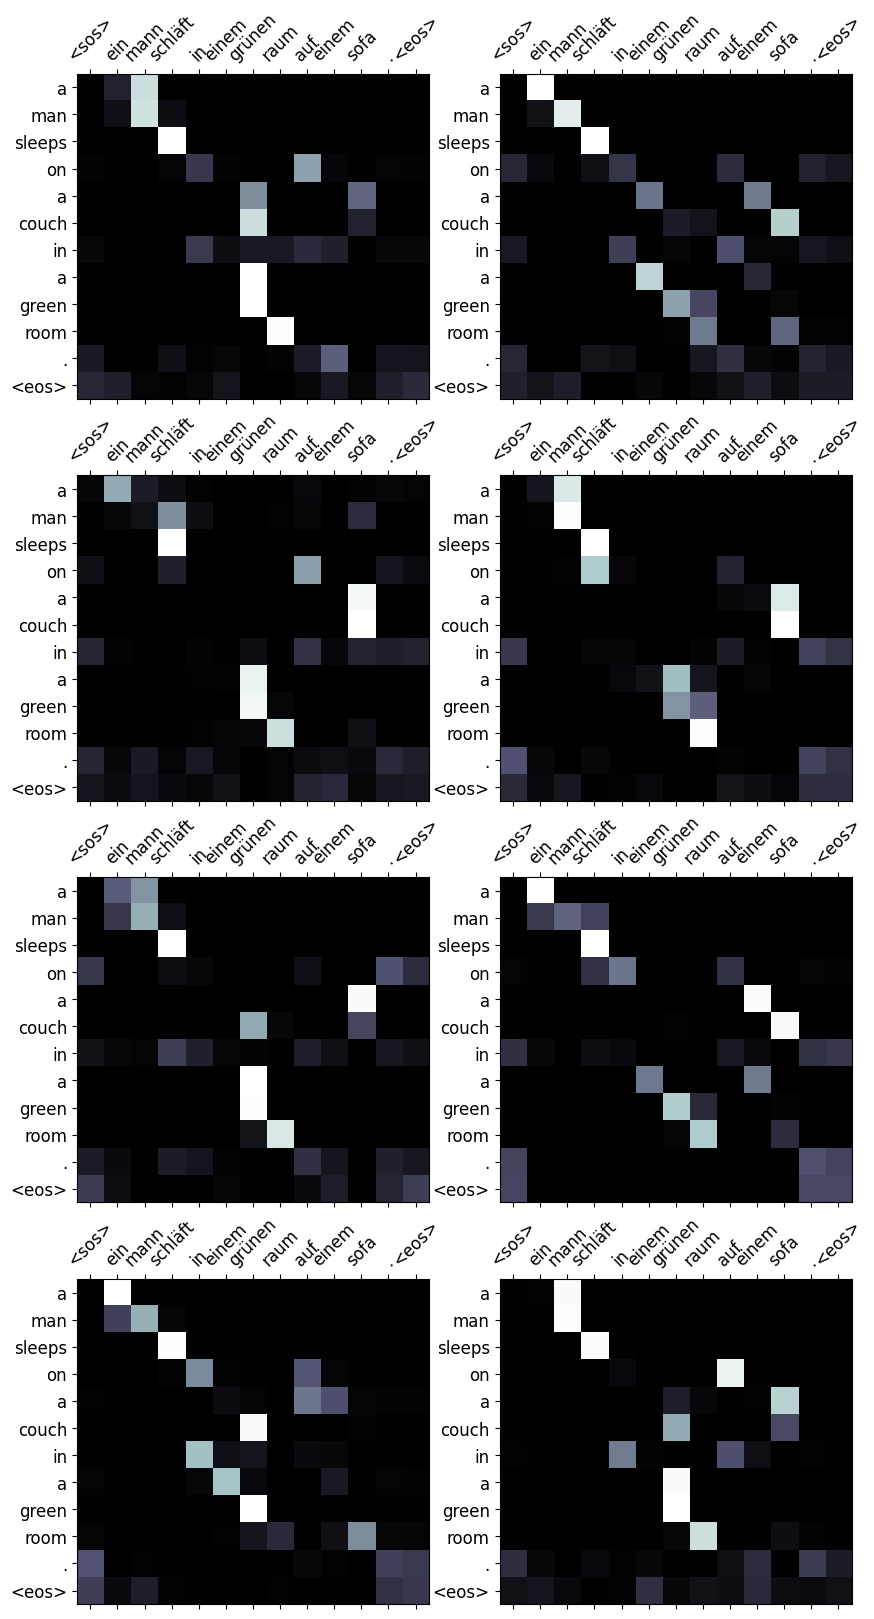

In [43]:
display_attention(src, translation, attention)

## Example 2

In [46]:
example_idx = 2

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'junge', 'mit', 'kopfhörern', 'sitzt', 'auf', 'den', 'schultern', 'einer', 'frau', '.']
trg = ['a', 'boy', 'wearing', 'headphones', 'sits', 'on', 'a', 'woman', "'s", 'shoulders', '.']


In [47]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'boy', 'with', 'headphones', 'sitting', 'on', 'his', 'shoulders', '.', '<eos>']


<ipython-input-39-f6f52b619417>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-39-f6f52b619417>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


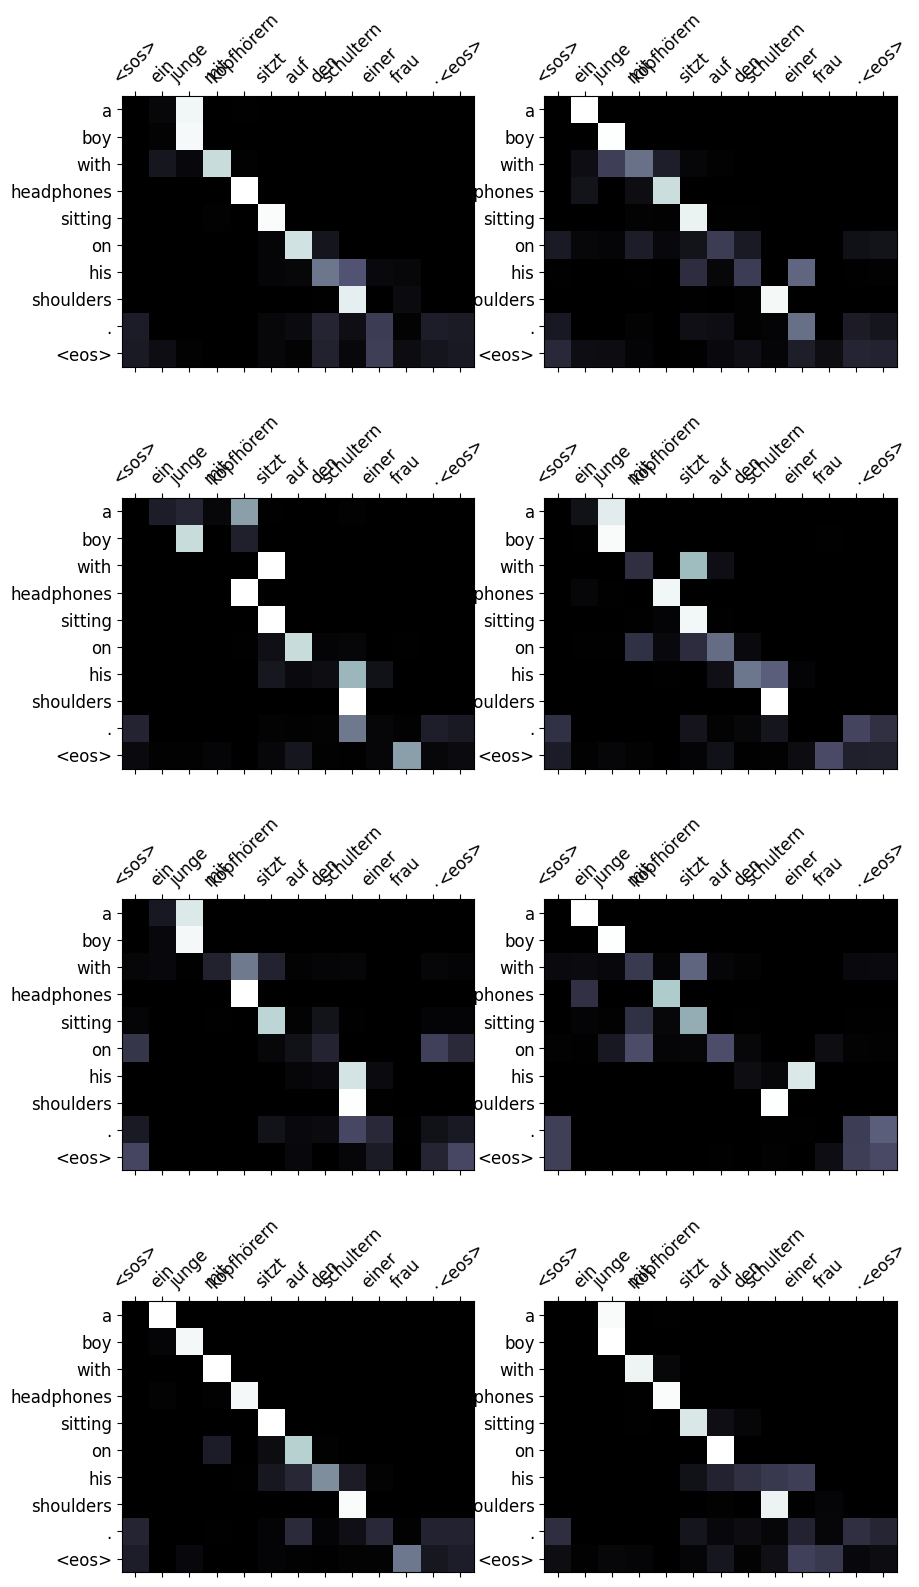

In [48]:
display_attention(src, translation, attention)

# Example 3

In [55]:
example_idx = 10

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen', '.']
trg = ['a', 'young', 'child', 'is', 'standing', 'alone', 'on', 'some', 'jagged', 'rocks', '.']


In [56]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'young', 'child', 'stands', 'alone', 'on', 'a', 'rock', 'formation', '.', '<eos>']


<ipython-input-39-f6f52b619417>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
<ipython-input-39-f6f52b619417>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


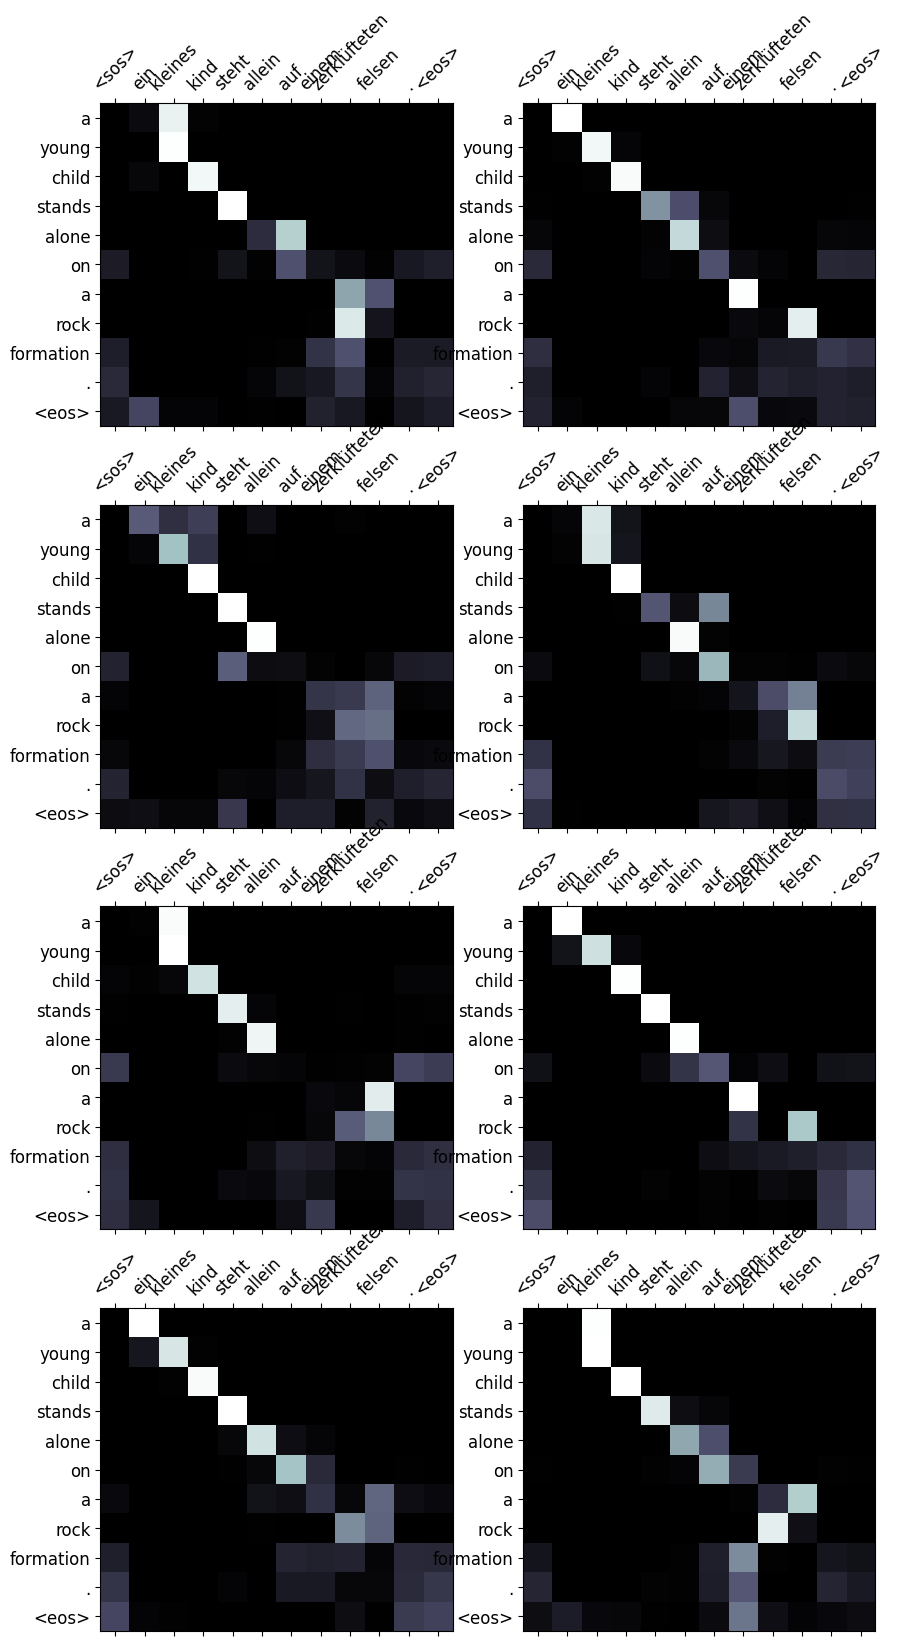

In [57]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [44]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):

    trgs = []
    pred_trgs = []

    for datum in data:

        src = vars(datum)['src']
        trg = vars(datum)['trg']

        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)

        #cut off <eos> token
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

    return bleu_score(pred_trgs, trgs)

In [45]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.78


## Tuned Seq2Seq Transformer Model

In [100]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 16
DEC_HEADS = 16
ENC_PF_DIM = 768
DEC_PF_DIM = 768
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

In [101]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

tuned_model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [102]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(tuned_model):,} trainable parameters')

The model has 9,826,309 trainable parameters


We initialize model weights

In [103]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

tuned_model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [104]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(tuned_model.parameters(), lr = LEARNING_RATE)

In [105]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [106]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(tuned_model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(tuned_model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(tuned_model.state_dict(), 'tuned_model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.318
	 Val. Loss: 3.135
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.930
	 Val. Loss: 2.405
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.291
	 Val. Loss: 2.015
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.903
	 Val. Loss: 1.830
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.637
	 Val. Loss: 1.719
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.439
	 Val. Loss: 1.661
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.281
	 Val. Loss: 1.641
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.151
	 Val. Loss: 1.625
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.037
	 Val. Loss: 1.635
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.942
	 Val. Loss: 1.667


In [107]:
# tuned_model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(tuned_model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.712


In [108]:
from torchtext.data.metrics import bleu_score

bleu_score = calculate_bleu(test_data, SRC, TRG, tuned_model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.89
